In [12]:
%%bash

pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 8.2 MB/s eta 0:00:00


In [13]:
import io
import os
import pathlib
import requests
import tarfile

import dtreeviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn import dummy, ensemble, feature_extraction, metrics, model_selection, pipeline, preprocessing, tree
import xgboost as xgb
import yellowbrick


In [2]:
DATA_ARCHIVE = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
DATA_DIR = pathlib.Path("./sample_data")

response = requests.get(DATA_ARCHIVE, stream=True)
with tarfile.open(fileobj=response.raw, mode="r|gz") as t:
    t.extractall(DATA_DIR)


In [3]:
def _reviews_to_df(filepath, sentiment):
    d = {"text": [], "sentiment": []}
    review_filepaths = sorted(filepath.glob("*.txt"))
    for review_filepath in review_filepaths:
        with open(review_filepath, 'r') as f:
            review = f.read()
        d["text"].append(review)
        d["sentiment"].append("positive" if sentiment == "pos" else "negative")
    df = pd.DataFrame.from_dict(d)
    return df


def _combine_reviews():
    dfs = []
    for split in ["train", "test"]:
        for sentiment in ["pos", "neg"]:
            df = _reviews_to_df(DATA_DIR / "aclImdb" / split / sentiment, sentiment)
            dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df


def partition_reviews(seed=42, test_size=0.2):
    combined_df = _combine_reviews()
    random_state = np.random.RandomState(seed)
    train_df, _val_df = model_selection.train_test_split(
        combined_df,
        random_state=random_state,
        shuffle=True,
        stratify=combined_df["sentiment"],
        test_size=test_size
    )

    # split the _val_df equally into val and test sets
    val_df, test_df = model_selection.train_test_split(
        _val_df,
        random_state=random_state,
        shuffle=True,
        stratify=_val_df["sentiment"],
        test_size=0.5
    )

    return train_df, val_df, test_df


In [4]:
train_df, val_df, test_df = partition_reviews(seed=42)

In [5]:
vectorizer_hyperparams = {
    "lowercase": True,
    "max_df": 0.9, # ignore words that show up in more than 90% of reviews
    "min_df": 0.1, # ignore words than show up in less than 10% of reviews
    "norm": "l2", # normalize rows using
    "dtype": np.float32,
}

features_preprocessing = pipeline.make_pipeline(
    feature_extraction.text.TfidfVectorizer(
        **vectorizer_hyperparams,
    ),
    preprocessing.FunctionTransformer(lambda csr: csr.toarray(), lambda arr: sparse.csr_matrix(arr))
)

label_encoder = preprocessing.LabelEncoder()

In [6]:
X_train = features_preprocessing.fit_transform(train_df.loc[:, "text"])
y_train = label_encoder.fit_transform(train_df.loc[:, "sentiment"])

X_val = features_preprocessing.transform(val_df.loc[:, "text"])
y_val = label_encoder.fit_transform(val_df.loc[:, "sentiment"])

X_test = features_preprocessing.transform(test_df.loc[:, "text"])
y_test = label_encoder.fit_transform(test_df.loc[:, "sentiment"])


In [ ]:
xgb.XGBClassifier?

In [7]:
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [8]:
print(f"Training accuracy: {xgb_classifier.score(X_train, y_train)}")
print(f"Validation accuracy: {xgb_classifier.score(X_val, y_val)}")

Training accuracy: 0.910925
Validation accuracy: 0.7668


In [9]:
xgb_classifier = xgb.XGBClassifier(n_estimators=2, max_depth=2, random_state=42)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=2, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [10]:
print(f"Training accuracy: {xgb_classifier.score(X_train, y_train)}")
print(f"Validation accuracy: {xgb_classifier.score(X_val, y_val)}")

Training accuracy: 0.651625
Validation accuracy: 0.653


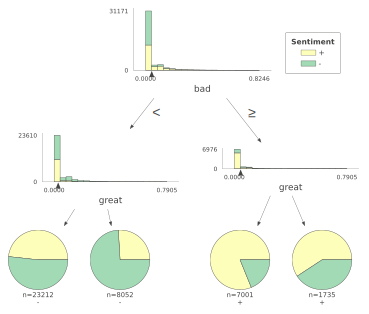

In [17]:
_vocabulary = features_preprocessing["tfidfvectorizer"].vocabulary_
_by_values = sorted(_vocabulary.items(), key=lambda item: item[1])
feature_names = [k for k, _ in _by_values]

viz = dtreeviz.model(
    xgb_classifier,
    X_train=X_train,
    y_train=y_train,
    target_name='Sentiment',
    feature_names=feature_names,
    class_names=['+', '-'],
    tree_index=0
)
viz.view(depth_range_to_display=[0,2])

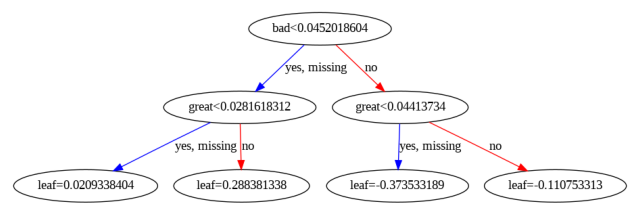

In [33]:
xgb_classifier.get_booster().feature_names = feature_names
_ = xgb.plot_tree(
    xgb_classifier,
    num_trees=0
)

In [28]:
X_train[[0], _vocabulary["bad"]]

array([0.], dtype=float32)

In [29]:
X_train[[0], _vocabulary["great"]]

array([0.1174482], dtype=float32)

In [36]:
def softmax(logits):
    return np.exp(logits) / np.sum(np.exp(logits))


softmax(0.288381338)

1.0

In [26]:
xgb_classifier.predict_proba(X_train[[0], :])

array([[0.3994156, 0.6005844]], dtype=float32)

In [35]:
_predictions = xgb_classifier.predict(X_train[[0], :])
label_encoder.inverse_transform(_predictions)

array(['positive'], dtype=object)

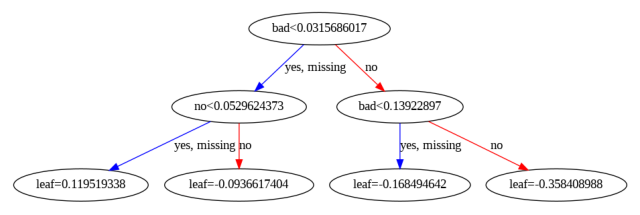

In [37]:
_ = xgb.plot_tree(
    xgb_classifier,
    num_trees=1
)

In [38]:
X_train[[0], _vocabulary["no"]]

array([0.], dtype=float32)

In [39]:
softmax(0.288381338 + 0.119519338)

1.0